### Libraries & Data

In [28]:
# Libraries and helpers

# Librarires
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import matplotlib.dates as mdates
import gspread

# Set up repo root path
import os
os.chdir("..")

# Helpers
from src import config
from src import help_functions as hf
from history_aware_relative_stratified_training_load import config as sub_config

# Configs
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", None)

In [29]:
# Get Training data

user = "urh"
user_config = config.USER_CONFIGURATIONS[user]

googleDrive_client = gspread.authorize(config.DRIVE_CREDENTIALS)
training_data, _ = hf.import_google_sheet(
    googleDrive_client=googleDrive_client, 
    filename=user_config["gdrive_activity_log_filename"], 
    sheet_name=config.BASIC_ACTIVITY_STATISTICS_SHEET_NAME
    )

training_data = hf.data_safe_convert_to_numeric(training_data)

In [30]:
# Get HASR-TL data

user = "urh"
user_config = config.USER_CONFIGURATIONS[user]

googleDrive_client = gspread.authorize(config.DRIVE_CREDENTIALS)
hasr_tl_data, _ = hf.import_google_sheet(
    googleDrive_client=googleDrive_client, 
    filename=user_config["gdrive_activity_log_filename"], 
    sheet_name=sub_config.HASR_TL_SHEET_NAME
    )

hasr_tl_data = hf.data_safe_convert_to_numeric(hasr_tl_data)
hasr_tl_data["Datetime"] = pd.to_datetime(hasr_tl_data[["Year", "Month", "Day"]])

### How do we weight the days? Baseline & Recent

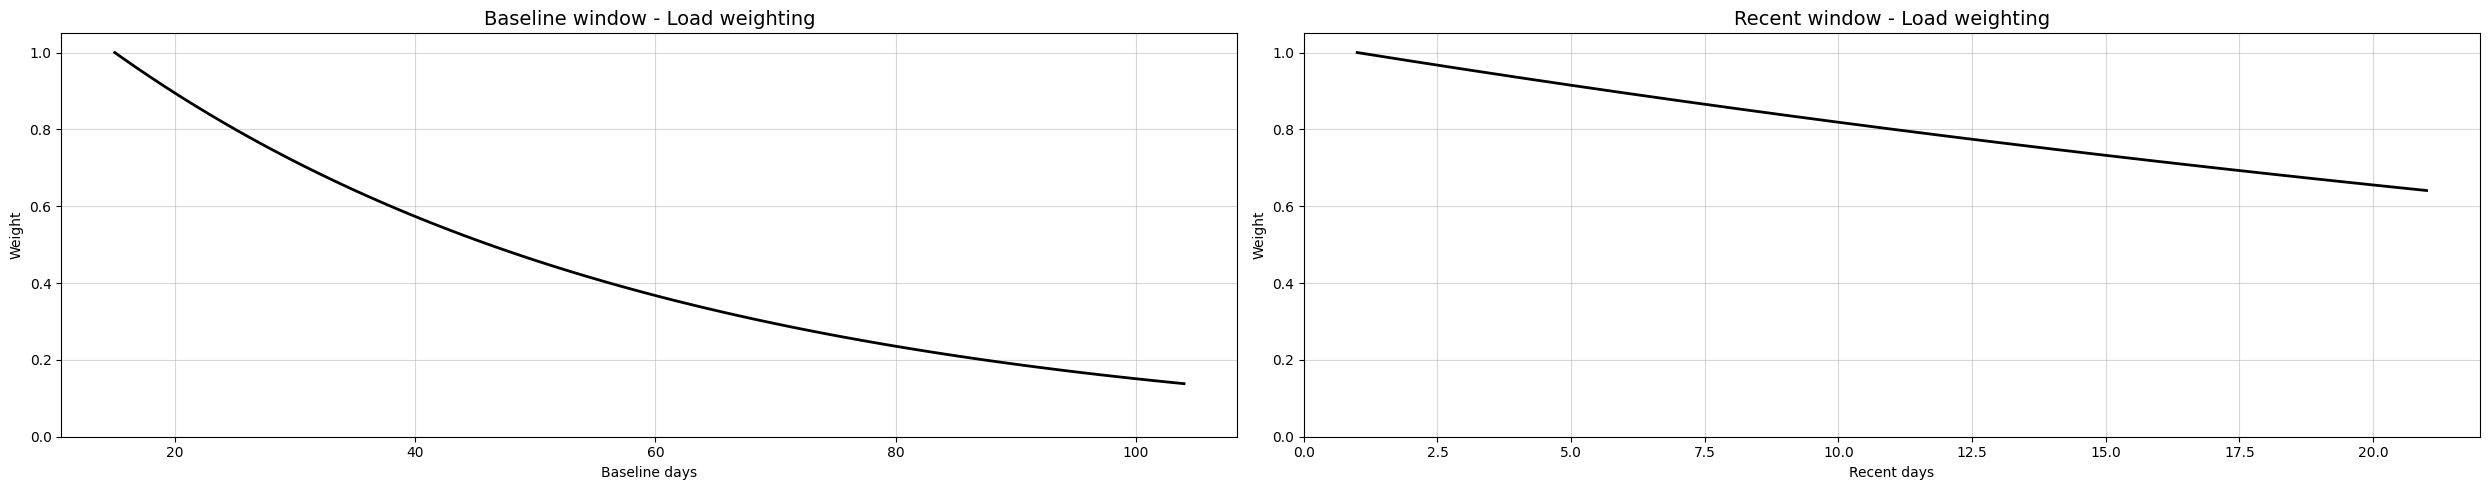

In [31]:
# How do we weight the days?

fig, ax = plt.subplots(1,2, figsize=(25,5))

ax[0].set_title("Baseline window - Load weighting", fontsize=14)
baseline_window_days = range(1, sub_config.BASELINE_WINDOW+1)
baseline_window_weights = np.array([sub_config.LAMBDA_BASE ** (j-1) for j in baseline_window_days])
ax[0].plot(np.repeat(14, 90) + baseline_window_days, baseline_window_weights, color="black", linewidth=2)
ax[0].set_xlabel("Baseline days")


ax[1].set_title("Recent window - Load weighting", fontsize=14)
recent_window_days = range(1, sub_config.RECENT_WINDOW+1)
recent_window_weights = np.array([sub_config.LAMBDA_BASE ** (j-1) for j in recent_window_days])
ax[1].plot(recent_window_days, recent_window_weights, color="black", linewidth=2)
ax[1].set_xlabel("Recent days")

for i in [0,1]:
    ax[i].set_ylim(0,1.05)
    ax[i].set_ylabel("Weight")
    ax[i].grid(alpha=0.5)

plt.tight_layout()
plt.show()

fig.savefig("analysissaved_filed.png", dpi=150, bbox_inches="tight")

### Training Load distribution ~ Easy, Hard, Long

In [32]:
# Prepare data

tt_classification_data = (
    training_data
    .assign(Datetime = lambda df: pd.to_datetime(df[["Year", "Month", "Day"]]))
    .groupby("Datetime")
    .agg({
        "Training load": "sum",
        "Distance [km]": "sum",
        "Duration [h]": "sum",
        "Activity type": lambda x: " | ".join(map(str, x)),  
        "Description": lambda x: " | ".join(x)  
    })
    .reset_index()
)

tt_classification_data["training_type_description"] = pd.Series(dtype="object")

# Rest days
rest_mask = tt_classification_data["Description"] == "Rest"
tt_classification_data.loc[rest_mask, "training_type_description"] = "Rest"

# Eays days (No special description, duration < 1.5h)
easy_mask = (
    (
        (tt_classification_data["Duration [h]"] <= 2.0) &
        (tt_classification_data["Description"].str.contains("Running|Workout|Aerobni|Lahkoten|Hiking|Aktivacija", case=False, na=False)) &
        ~(tt_classification_data["Description"].str.contains("Race", case=False, na=False)) & 
        (tt_classification_data["training_type_description"].isnull())
    )
    | (
        tt_classification_data["Description"].str.contains("Biking", case=False, na=False) & 
        (tt_classification_data["training_type_description"].isnull())
    )
)
tt_classification_data.loc[easy_mask, "training_type_description"] = "Easy"

# Hard days (Special description, duration < 2h)
hard_mask = (
    (tt_classification_data["Duration [h]"] <= 1.5) &
    (tt_classification_data["Description"] .str.contains("INT|TT|PWH|LT|x")) &
    ~(tt_classification_data["Description"].str.contains("Running|Biking|Workout|Aerobni|Lahkoten|Hiking|Aktivacija", case=False, na=False)) & 
    (tt_classification_data["training_type_description"].isnull())
)
tt_classification_data.loc[hard_mask, "training_type_description"] = "Hard"

# Long days (No special description, duration >= 2h)
long_mask = (
    (tt_classification_data["Duration [h]"] >= 2.0)  &
    (tt_classification_data["Description"].str.contains("Running|Dolgi|Tek|x", case=False, na=False)) & 
    # ~(tt_classification_data["Description"].str.contains("Biking", case=False, na=False)) & 
    (tt_classification_data["training_type_description"].isnull())
)
tt_classification_data.loc[long_mask, "training_type_description"] = "Long"

# Other (medium long days, other ...)
other_mask = (
    (tt_classification_data["training_type_description"].isnull())
)
tt_classification_data.loc[other_mask, "training_type_description"] = "Other"

In [33]:
# About
print("Training type - description:")
print("-----------------------------------------------------")
for value in ["Easy", "Hard", "Long", "Other", "Rest"]:
    data_tmp = tt_classification_data.query("training_type_description == @value")
    print("{} ~> {} ({}% | *{}%) ~> [Q10 = {}, mean = {}, median = {}, Q90 = {}, SD = {}]".format(
        value, 
        data_tmp.shape[0],
        round(data_tmp.shape[0]/tt_classification_data.shape[0] * 100, 2),
        round(data_tmp.shape[0]/tt_classification_data.query("training_type_description != 'Rest'").shape[0] * 100, 2),
        round(np.quantile(data_tmp["Training load"], 0.1), 2),
        round(data_tmp["Training load"].mean(), 2),
        round(data_tmp["Training load"].median(), 2),
        round(np.quantile(data_tmp["Training load"], 0.1), 2),
        round(data_tmp["Training load"].std(), 2)
        ))
print("* ~> Without rest days included in proportions")

print("\nTraining load Quantile values:")
print("-----------------------------------------------------")
quantile_06 = tt_classification_data["Training load"].quantile(0.6)
quantile_085 = tt_classification_data["Training load"].quantile(0.85)
print("Quantile 0.6 = {}".format(round(quantile_06, 1)))
print("Quantile 0.85 = {}".format(round(quantile_085, 1)))

Training type - description:
-----------------------------------------------------
Easy ~> 202 (54.45% | *63.12%) ~> [Q10 = 51.21, mean = 103.32, median = 96.2, Q90 = 51.21, SD = 49.46]
Hard ~> 37 (9.97% | *11.56%) ~> [Q10 = 130.06, mean = 183.14, median = 177.1, Q90 = 130.06, SD = 59.57]
Long ~> 56 (15.09% | *17.5%) ~> [Q10 = 135.75, mean = 228.46, median = 207.6, Q90 = 135.75, SD = 98.78]
Other ~> 25 (6.74% | *7.81%) ~> [Q10 = 96.34, mean = 179.64, median = 189.3, Q90 = 96.34, SD = 65.66]
Rest ~> 51 (13.75% | *15.94%) ~> [Q10 = 0.0, mean = 0.0, median = 0.0, Q90 = 0.0, SD = 0.0]
* ~> Without rest days included in proportions

Training load Quantile values:
-----------------------------------------------------
Quantile 0.6 = 131.2
Quantile 0.85 = 207.6


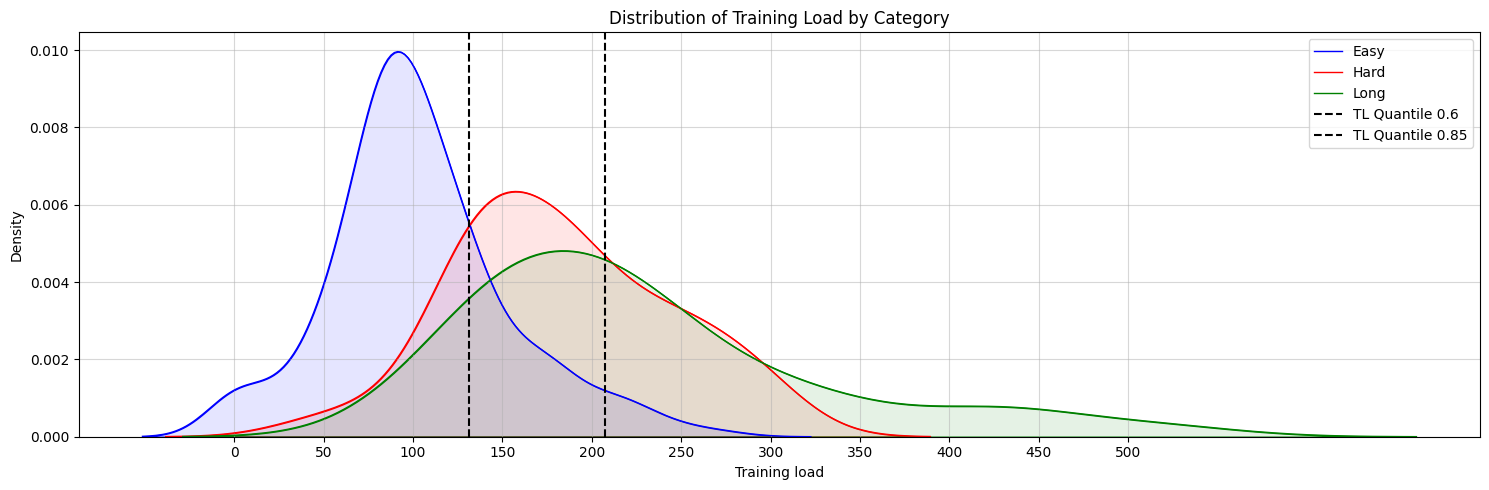

In [34]:
# Training load distribution
fig, ax = plt.subplots(1,1, figsize=(15,5))

colors = {"Easy": "blue", "Hard": "red", "Long": "green", "Other": "grey"}
categories = ["Easy", "Hard", "Long"] # "Other"

for cat in categories:
    tmp = tt_classification_data.query("training_type_description == @cat")["Training load"]
    color = colors[cat]
    sns.kdeplot(tmp, color=color, fill=True, alpha=0.1, ax=ax)
    sns.kdeplot(tmp, color=color, fill=False, alpha=1.0, ax=ax, label=cat, linewidth=1)

ax.axvline(x = quantile_06, color="black", linestyle="--", label = "TL Quantile 0.6")
ax.axvline(x = quantile_085, color="black", linestyle="--", label = "TL Quantile 0.85")

ax.set_xticks(np.arange(0, tt_classification_data["Training load"].max()+1, step=50))
ax.set_xlabel("Training load")
ax.set_ylabel("Density")
ax.set_title("Distribution of Training Load by Category")
ax.legend()

plt.grid(alpha=0.5)
plt.tight_layout()
plt.show()

### HASR-TL

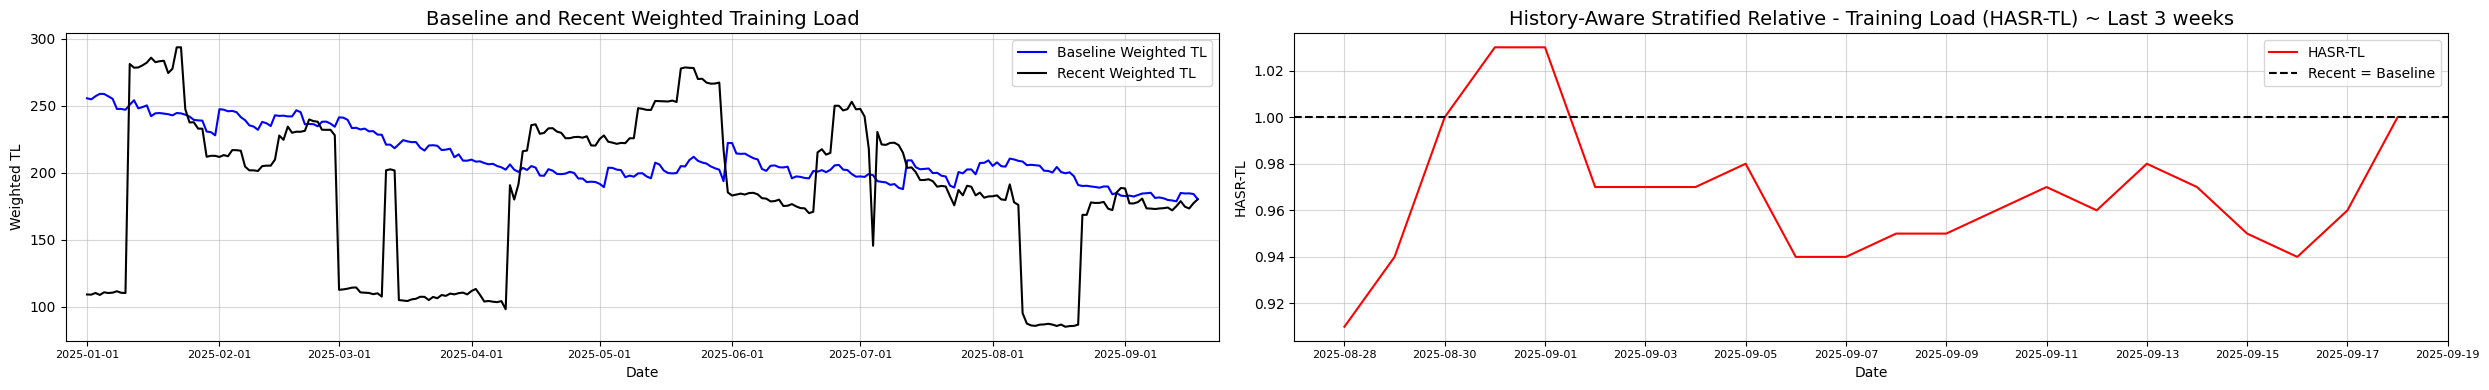

In [35]:
# HASRT-TL ~ Full & Last weeks

fig, ax = plt.subplots(1,2, figsize=(25,4))
indices = np.arange(0, len(hasr_tl_data["Datetime"]))
plot_data = hasr_tl_data.loc[hasr_tl_data[sub_config.HASR_TL_COLUMN_NAMES[0]].notnull(), :]
plot_data_recent = plot_data.loc[plot_data["Datetime"] >= plot_data["Datetime"].max() - pd.Timedelta(days=21), :]

ax[0].set_title("Baseline and Recent Weighted Training Load", fontsize=14)
ax[0].plot(plot_data["Datetime"], plot_data[sub_config.HASR_TL_COLUMN_NAMES[2]], color="blue", label="Baseline Weighted TL")
ax[0].plot(plot_data["Datetime"], plot_data[sub_config.HASR_TL_COLUMN_NAMES[1]], color="black", label="Recent Weighted TL")
ax[0].set_xlim(np.min(plot_data["Datetime"]) - datetime.timedelta(days=5), np.max(hasr_tl_data["Datetime"] + datetime.timedelta(days=5)))
ax[0].set_ylabel("Weighted TL")
ax[0].xaxis.set_major_locator(mdates.MonthLocator())  
ax[0].xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))

ax[1].set_title("History-Aware Stratified Relative - Training Load (HASR-TL) ~ Last 3 weeks", fontsize=14)
ax[1].plot(plot_data_recent["Datetime"], plot_data_recent[sub_config.HASR_TL_COLUMN_NAMES[0]], color="red", label="HASR-TL")
ax[1].axhline(y=1, color="black", linestyle="--", label="Recent = Baseline")
ax[1].set_xlim(np.min(plot_data_recent["Datetime"]) - datetime.timedelta(days=1), np.max(plot_data_recent["Datetime"] + datetime.timedelta(days=1)))
ax[1].set_ylabel("HASR-TL")
ax[1].xaxis.set_major_locator(mdates.DayLocator(interval=2))  
ax[1].xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))

for i in [0,1]:
    ax[i].legend()
    ax[i].set_xlabel("Date")
    ax[i].tick_params(axis="x", rotation=0, labelsize=8)
    ax[i].grid(alpha=0.5)

plt.tight_layout()
plt.show()

### Bucket level diagnostics

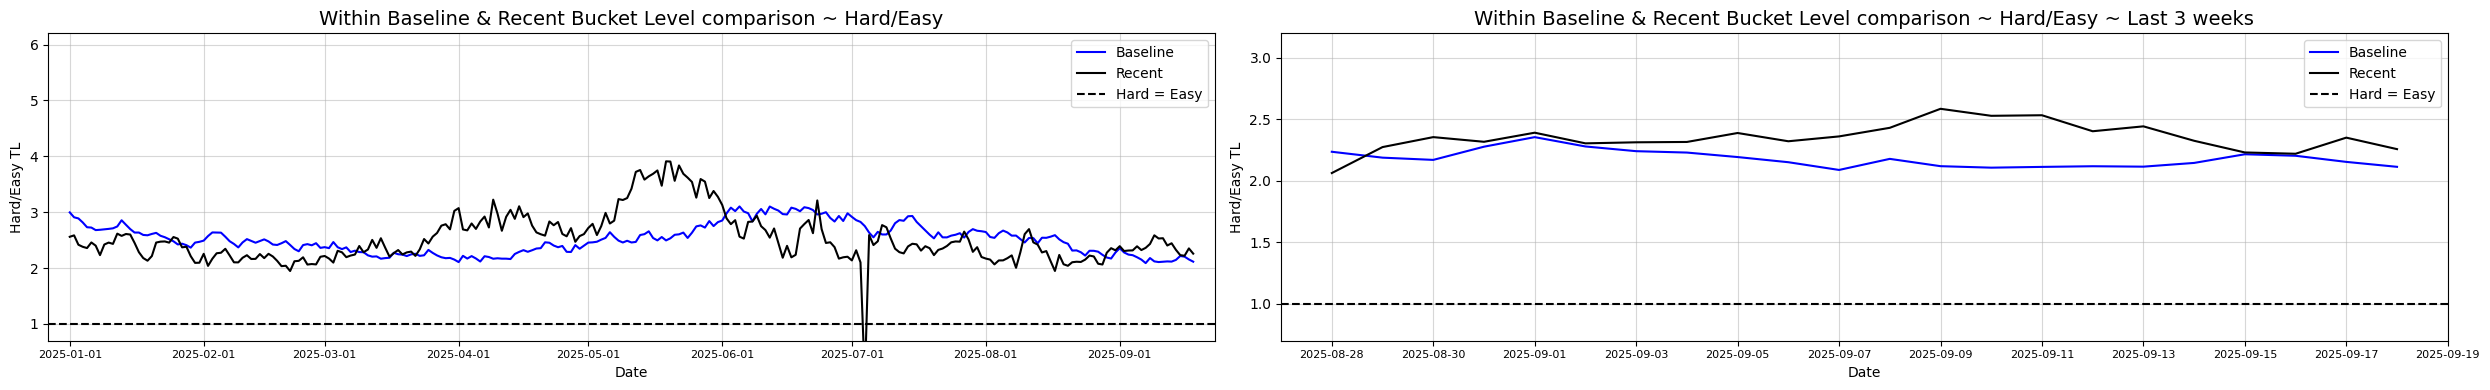

In [36]:
# Within window Bucket level comparison ~ Baseline [Hard vs. Easy] & Recent [Hard vs. Easy]

fig, ax = plt.subplots(1,2, figsize=(25,4))
indices = np.arange(0, len(hasr_tl_data["Datetime"]))
plot_data = hasr_tl_data.loc[hasr_tl_data[sub_config.HASR_TL_COLUMN_NAMES[0]].notnull(), :]
plot_data_recent = plot_data.loc[plot_data["Datetime"] >= plot_data["Datetime"].max() - pd.Timedelta(days=21), :]

ax[0].set_title("Within Baseline & Recent Bucket Level comparison ~ Hard/Easy", fontsize=14)
ax[0].plot(plot_data["Datetime"], plot_data[sub_config.BASELINE_SLA_VALUE_COLUMN_NAMES[1]] / plot_data[sub_config.BASELINE_SLA_VALUE_COLUMN_NAMES[0]], color="blue", label="Baseline")
ax[0].plot(plot_data["Datetime"], plot_data[sub_config.RECENT_SLA_VALUE_COLUMN_NAMES[1]] / plot_data[sub_config.RECENT_SLA_VALUE_COLUMN_NAMES[0]], color="black", label="Recent")
ax[0].set_ylabel("Hard/Easy TL")
ax[0].set_xlim(np.min(plot_data["Datetime"]) - datetime.timedelta(days=5), np.max(hasr_tl_data["Datetime"] + datetime.timedelta(days=5)))
ax[0].xaxis.set_major_locator(mdates.MonthLocator())  
ax[0].xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
ax[0].set_ylim(0.7, 6.2)

ax[1].set_title("Within Baseline & Recent Bucket Level comparison ~ Hard/Easy ~ Last 3 weeks", fontsize=14)
ax[1].plot(plot_data_recent["Datetime"], plot_data_recent[sub_config.BASELINE_SLA_VALUE_COLUMN_NAMES[1]] / plot_data_recent[sub_config.BASELINE_SLA_VALUE_COLUMN_NAMES[0]], color="blue", label="Baseline")
ax[1].plot(plot_data_recent["Datetime"], plot_data_recent[sub_config.RECENT_SLA_VALUE_COLUMN_NAMES[1]] / plot_data_recent[sub_config.RECENT_SLA_VALUE_COLUMN_NAMES[0]], color="black", label="Recent")
ax[1].set_ylabel("Hard/Easy TL")
ax[1].set_xlim(np.min(plot_data_recent["Datetime"]) - datetime.timedelta(days=1), np.max(plot_data_recent["Datetime"] + datetime.timedelta(days=1)))
ax[1].xaxis.set_major_locator(mdates.DayLocator(interval=2))  
ax[1].xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
ax[1].set_ylim(0.7, 3.2)

for i in [0,1]:
    ax[i].axhline(y=1, color="black", linestyle="--", label="Hard = Easy")
    ax[i].set_xlabel("Date")
    ax[i].tick_params(axis="x", rotation=0, labelsize=8)
    ax[i].legend()
    ax[i].grid(alpha=0.5)

plt.tight_layout()
plt.show()

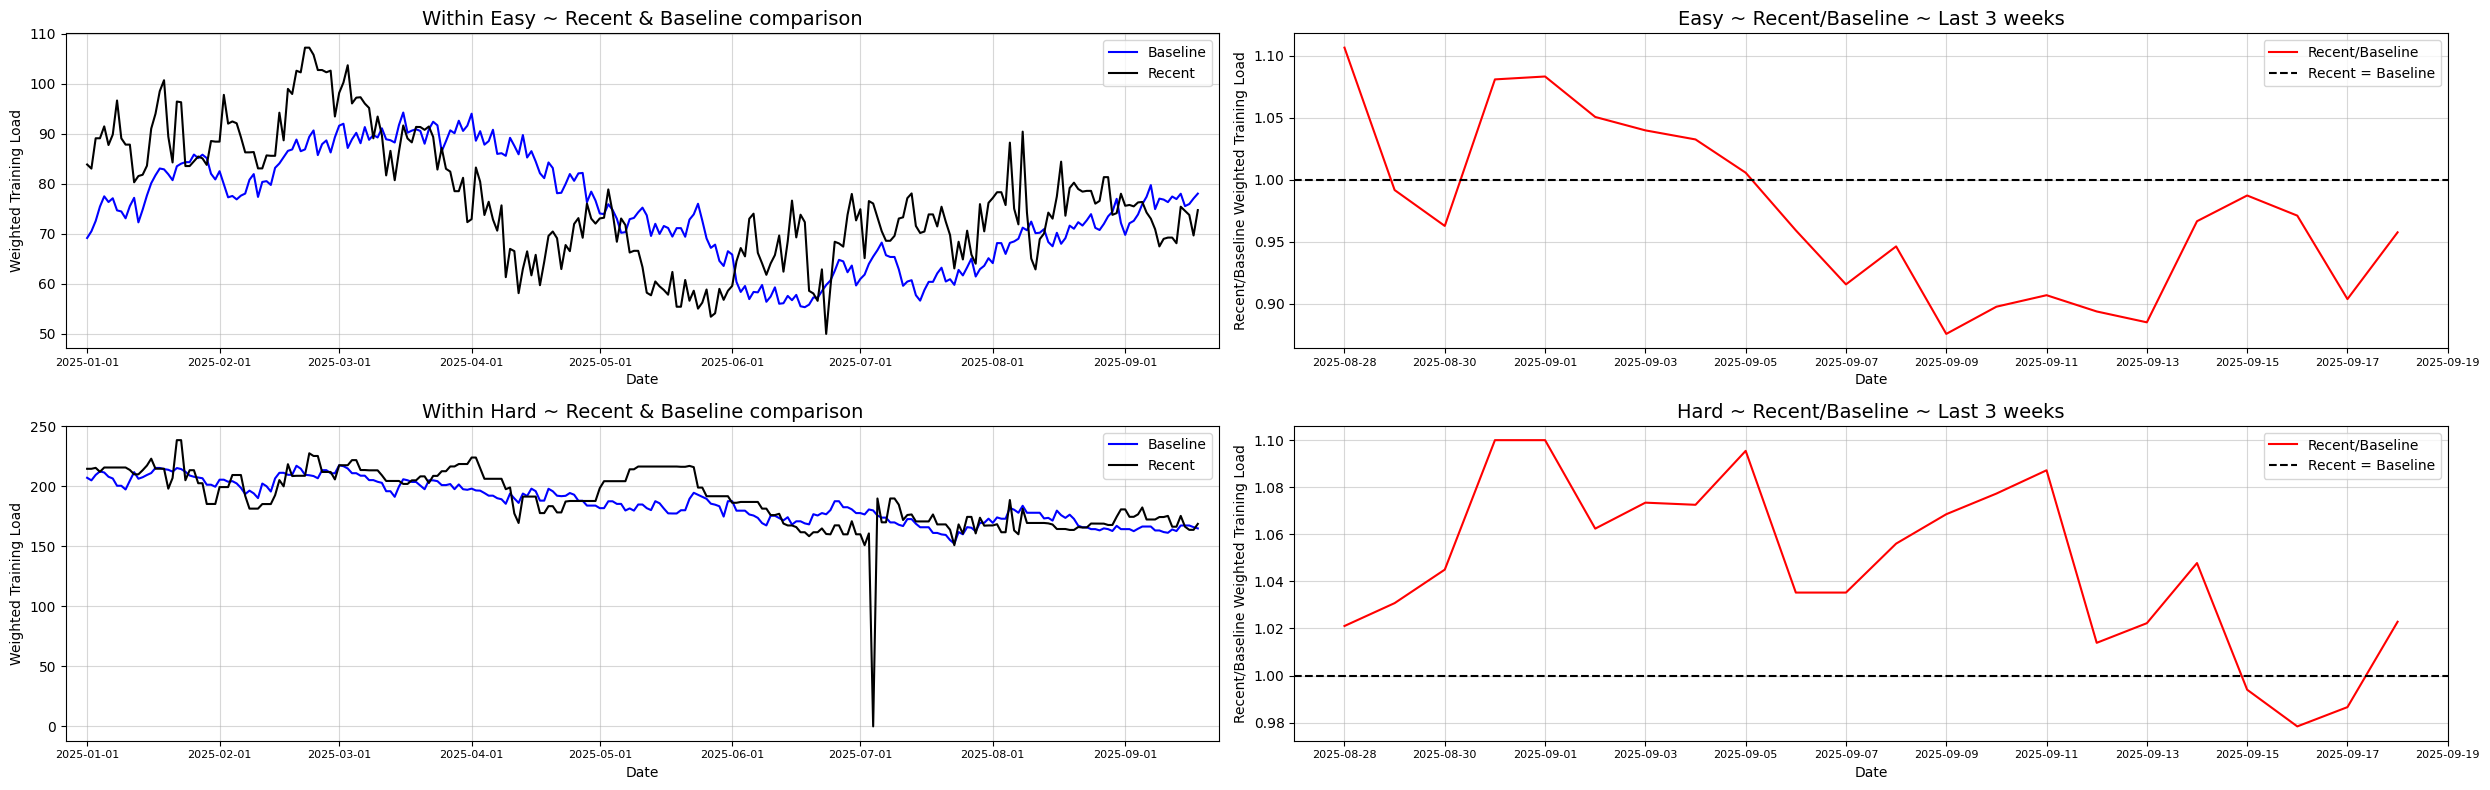

In [37]:
# Between windows bucket level comparison ~ Easy, Hard

fig, ax = plt.subplots(2,2, figsize=(25,8))
indices = np.arange(0, len(hasr_tl_data["Datetime"]))
plot_data = hasr_tl_data.loc[hasr_tl_data[sub_config.HASR_TL_COLUMN_NAMES[0]].notnull(), :]
plot_data_recent = plot_data.loc[plot_data["Datetime"] >= plot_data["Datetime"].max() - pd.Timedelta(days=21), :]

ax[0,0].set_title("Within Easy ~ Recent & Baseline comparison", fontsize=14)
ax[0,0].plot(plot_data["Datetime"], plot_data[sub_config.BASELINE_SLA_VALUE_COLUMN_NAMES[0]], color="blue", label="Baseline")
ax[0,0].plot(plot_data["Datetime"], plot_data[sub_config.RECENT_SLA_VALUE_COLUMN_NAMES[0]], color="black", label="Recent")
ax[0,0].set_ylabel("Weighted Training Load")
ax[0,0].set_xlim(np.min(plot_data["Datetime"]) - datetime.timedelta(days=5), np.max(plot_data["Datetime"] + datetime.timedelta(days=5)))
ax[0,0].xaxis.set_major_locator(mdates.MonthLocator())  
ax[0,0].xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))

ax[0,1].set_title("Easy ~ Recent/Baseline ~ Last 3 weeks", fontsize=14)
ax[0,1].plot(plot_data_recent["Datetime"], plot_data_recent[sub_config.RECENT_SLA_VALUE_COLUMN_NAMES[0]] / plot_data_recent[sub_config.BASELINE_SLA_VALUE_COLUMN_NAMES[0]], color="red", label="Recent/Baseline")
ax[0,1].axhline(y=1, color="black", linestyle="--", label="Recent = Baseline")
ax[0,1].set_ylabel("Recent/Baseline Weighted Training Load")
ax[0,1].set_xlim(np.min(plot_data_recent["Datetime"]) - datetime.timedelta(days=1), np.max(plot_data_recent["Datetime"] + datetime.timedelta(days=1)))
ax[0,1].xaxis.set_major_locator(mdates.DayLocator(interval=2))  
ax[0,1].xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))

ax[1,0].set_title("Within Hard ~ Recent & Baseline comparison", fontsize=14)
ax[1,0].plot(plot_data["Datetime"], plot_data[sub_config.BASELINE_SLA_VALUE_COLUMN_NAMES[1]], color="blue", label="Baseline")
ax[1,0].plot(plot_data["Datetime"], plot_data[sub_config.RECENT_SLA_VALUE_COLUMN_NAMES[1]], color="black", label="Recent")
ax[1,0].set_ylabel("Weighted Training Load")
ax[1,0].set_xlim(np.min(plot_data["Datetime"]) - datetime.timedelta(days=5), np.max(plot_data["Datetime"] + datetime.timedelta(days=5)))
ax[1,0].xaxis.set_major_locator(mdates.MonthLocator())  
ax[1,0].xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))

ax[1,1].set_title("Hard ~ Recent/Baseline ~ Last 3 weeks", fontsize=14)
ax[1,1].plot(plot_data_recent["Datetime"], plot_data_recent[sub_config.RECENT_SLA_VALUE_COLUMN_NAMES[1]] / plot_data_recent[sub_config.BASELINE_SLA_VALUE_COLUMN_NAMES[1]], color="red", label="Recent/Baseline")
ax[1,1].axhline(y=1, color="black", linestyle="--", label="Recent = Baseline")
ax[1,1].set_ylabel("Recent/Baseline Weighted Training Load")
ax[1,1].set_xlim(np.min(plot_data_recent["Datetime"]) - datetime.timedelta(days=1), np.max(plot_data_recent["Datetime"] + datetime.timedelta(days=1)))
ax[1,1].xaxis.set_major_locator(mdates.DayLocator(interval=2))  
ax[1,1].xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))

for i in [0,1]:
    for j in [0,1]:
        ax[i,j].set_xlabel("Date")
        ax[i,j].tick_params(axis="x", rotation=0, labelsize=8)
        ax[i,j].legend()
        ax[i,j].grid(alpha=0.5)

plt.tight_layout()
plt.show()

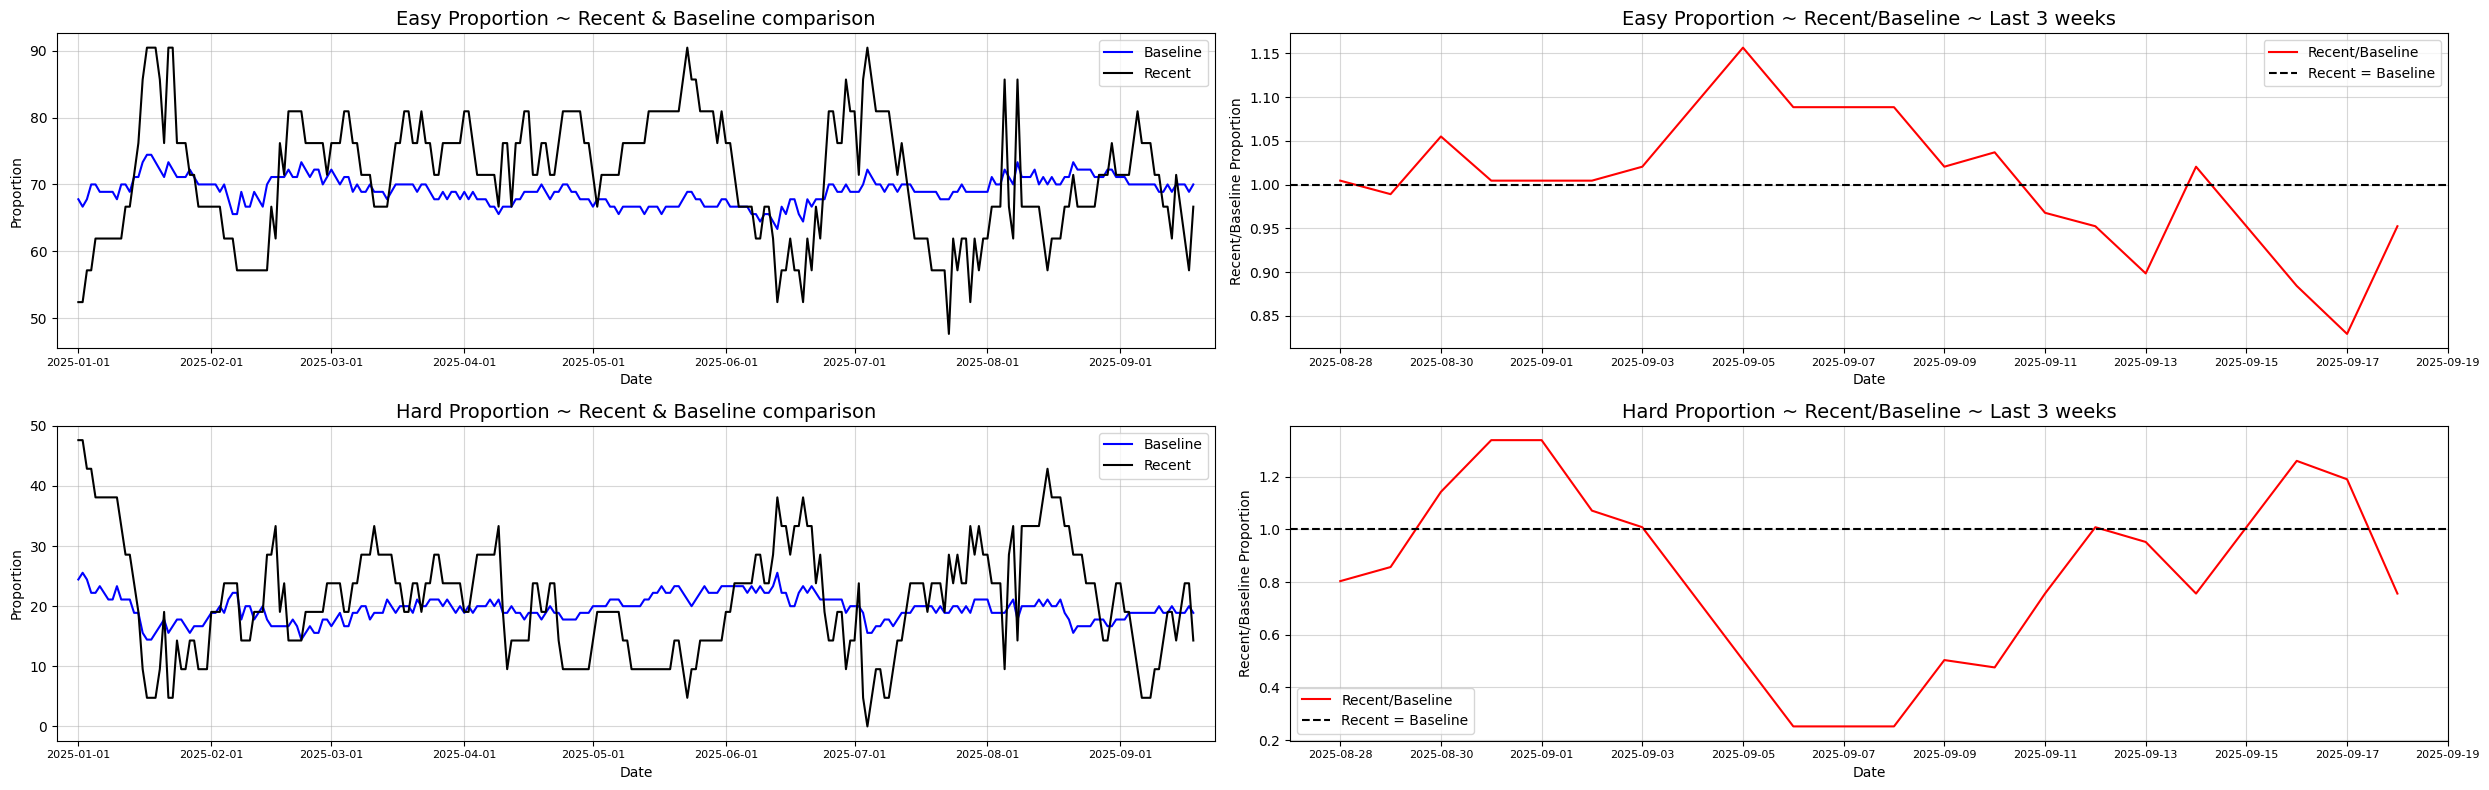

In [38]:
# Between windows bucket proportion comparison ~ Easy, Hard

fig, ax = plt.subplots(2,2, figsize=(25,8))
indices = np.arange(0, len(hasr_tl_data["Datetime"]))
plot_data = hasr_tl_data.loc[hasr_tl_data[sub_config.HASR_TL_COLUMN_NAMES[0]].notnull(), :]
plot_data_recent = plot_data.loc[plot_data["Datetime"] >= plot_data["Datetime"].max() - pd.Timedelta(days=21), :]

ax[0,0].set_title("Easy Proportion ~ Recent & Baseline comparison", fontsize=14)
ax[0,0].plot(plot_data["Datetime"], plot_data[sub_config.BASELINE_SLA_PROPORTION_COLUMN_NAMES[0]], color="blue", label="Baseline")
ax[0,0].plot(plot_data["Datetime"], plot_data[sub_config.RECENT_SLA_PROPORTION_COLUMN_NAMES[0]], color="black", label="Recent")
ax[0,0].set_ylabel("Proportion")
ax[0,0].set_xlim(np.min(plot_data["Datetime"]) - datetime.timedelta(days=5), np.max(plot_data["Datetime"] + datetime.timedelta(days=5)))
ax[0,0].xaxis.set_major_locator(mdates.MonthLocator())  
ax[0,0].xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))

ax[0,1].set_title("Easy Proportion ~ Recent/Baseline ~ Last 3 weeks", fontsize=14)
ax[0,1].plot(plot_data_recent["Datetime"], plot_data_recent[sub_config.RECENT_SLA_PROPORTION_COLUMN_NAMES[0]] / plot_data_recent[sub_config.BASELINE_SLA_PROPORTION_COLUMN_NAMES[0]], color="red", label="Recent/Baseline")
ax[0,1].axhline(y=1, color="black", linestyle="--", label="Recent = Baseline")
ax[0,1].set_ylabel("Recent/Baseline Proportion")
ax[0,1].set_xlim(np.min(plot_data_recent["Datetime"]) - datetime.timedelta(days=1), np.max(plot_data_recent["Datetime"] + datetime.timedelta(days=1)))
ax[0,1].xaxis.set_major_locator(mdates.DayLocator(interval=2))  
ax[0,1].xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))

ax[1,0].set_title("Hard Proportion ~ Recent & Baseline comparison", fontsize=14)
ax[1,0].plot(plot_data["Datetime"], plot_data[sub_config.BASELINE_SLA_PROPORTION_COLUMN_NAMES[1]], color="blue", label="Baseline")
ax[1,0].plot(plot_data["Datetime"], plot_data[sub_config.RECENT_SLA_PROPORTION_COLUMN_NAMES[1]], color="black", label="Recent")
ax[1,0].set_ylabel("Proportion")
ax[1,0].set_xlim(np.min(plot_data["Datetime"]) - datetime.timedelta(days=5), np.max(plot_data["Datetime"] + datetime.timedelta(days=5)))
ax[1,0].xaxis.set_major_locator(mdates.MonthLocator())  
ax[1,0].xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))

ax[1,1].set_title("Hard Proportion ~ Recent/Baseline ~ Last 3 weeks", fontsize=14)
ax[1,1].plot(plot_data_recent["Datetime"], plot_data_recent[sub_config.RECENT_SLA_PROPORTION_COLUMN_NAMES[1]] / plot_data_recent[sub_config.BASELINE_SLA_PROPORTION_COLUMN_NAMES[1]], color="red", label="Recent/Baseline")
ax[1,1].axhline(y=1, color="black", linestyle="--", label="Recent = Baseline")
ax[1,1].set_ylabel("Recent/Baseline Proportion")
ax[1,1].set_xlim(np.min(plot_data_recent["Datetime"]) - datetime.timedelta(days=1), np.max(plot_data_recent["Datetime"] + datetime.timedelta(days=1)))
ax[1,1].xaxis.set_major_locator(mdates.DayLocator(interval=2))  
ax[1,1].xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))

for i in [0,1]:
    for j in [0,1]:
        ax[i,j].set_xlabel("Date")
        ax[i,j].tick_params(axis="x", rotation=0, labelsize=8)
        ax[i,j].legend()
        ax[i,j].grid(alpha=0.5)

plt.tight_layout()
plt.show()

### Recent Training Classifcation

In [39]:
# Prepare data

session_classification_data = hasr_tl_data.query("`Session Baseline Rank`.notnull()")[["Datetime", "Session Baseline Rank", "Session Baseline Class"]].merge(
    tt_classification_data[["Datetime", "Description", "training_type_description"]], on = "Datetime", how="left")

session_classification_data["training_type_description"] = session_classification_data["training_type_description"].replace({"Rest": "Easy"})

In [40]:
# Analysis

class_metrics = {}
for single_class in ["Easy", "Hard", "Long"]:
    data_type = session_classification_data.query("`Session Baseline Class` == @single_class")
    class_metrics[single_class] = {
        "Proportion of class in 'by hand' classified": (data_type["training_type_description"] == single_class).mean(),
        "Correct Session Baseline Rank avg.": data_type.query("training_type_description == @single_class")["Session Baseline Rank"].mean(),
        "Incorrect Session Baseline Rank avg.": data_type.query("training_type_description != @single_class")["Session Baseline Rank"].mean(),
        } 

for single_class in ["Easy", "Hard", "Long"]:
    print("\n" + single_class)
    print("------------------------------------")
    for key, value in class_metrics[single_class].items():
        print(f"{key}: {round(value, 2)}")


Easy
------------------------------------
Proportion of class in 'by hand' classified: 0.87
Correct Session Baseline Rank avg.: 0.34
Incorrect Session Baseline Rank avg.: 0.57

Hard
------------------------------------
Proportion of class in 'by hand' classified: 0.17
Correct Session Baseline Rank avg.: 0.8
Incorrect Session Baseline Rank avg.: 0.8

Long
------------------------------------
Proportion of class in 'by hand' classified: 0.6
Correct Session Baseline Rank avg.: 0.96
Incorrect Session Baseline Rank avg.: 0.96


In [41]:
session_classification_data.query("`Session Baseline Class` == 'Hard'")

,Datetime,Session Baseline Rank,Session Baseline Class,Description,training_type_description
0,2025-01-01,0.82,Hard,"Moravce - DT 3x10' TT 4-6% naklon, RPE",Hard
3,2025-01-04,0.74,Hard,Kamnik - DT/hike 90' + PWH 2x20',Other
20,2025-01-21,0.88,Hard,Moravce - Lahkoten tek + pospeševanja 10x,Easy
26,2025-01-27,0.73,Hard,Moravce - Lahkoten tek + pospeševanja 10x,Easy
31,2025-02-01,0.76,Hard,Moravce - INT 5x3' 4-10%,Hard
34,2025-02-04,0.90,Hard,"Kranj - INT 5x1km, ravnina, RPE",Hard
37,2025-02-07,0.74,Hard,"Moravce - Lahkoten tek + strides 2x6x30"",",Easy
41,2025-02-11,0.79,Hard,"Kranj - INT 4x4' (4-10% naklon), RPE",Hard
44,2025-02-14,0.72,Hard,"Kranj - Klančki 10x20"", RPE",Hard
52,2025-02-22,0.87,Hard,"Kranj - DT Steady State 2x30', tempo",Other


In [42]:
session_classification_data.query("`Session Baseline Class` == 'Long'")

,Datetime,Session Baseline Rank,Session Baseline Class,Description,training_type_description
10,2025-01-11,0.97,Long,Race Nazarje Trail Running,Long
23,2025-01-24,0.95,Long,Kranj - INT 5x3' ravnina,Hard
24,2025-01-25,0.92,Long,Moravce Trail Running,Long
28,2025-01-29,0.93,Long,Moravce - INT 6x3' 4-10%,Hard
38,2025-02-08,0.95,Long,Moravce Trail Running | Moravce - DT 3x10' TT 4-10% naklon + hiter,Long
101,2025-04-12,1.00,Long,Race Zalec Trail Running,Long
112,2025-04-23,1.00,Long,"Kranj - DT 3h + Steady State 2x30', RPE",Long
118,2025-04-29,0.99,Long,Greve in Chianti - INT decreasing HII RPE,Hard
129,2025-05-10,1.00,Long,Race Idrija Trail Running,Long
149,2025-05-30,0.93,Long,"Dugi Rat - Dolgi trail tek - vzpon, RPE | Dugi Rat Trail Running",Long
